<a href="https://colab.research.google.com/github/Arashfd75/Gradual_Learning_Colorization/blob/main/gradual_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D,Conv1D, ReLU, ZeroPadding2D, SeparableConv2D,GlobalAveragePooling2D
from keras.layers import Activation, Dense, Dropout, Flatten, InputLayer, Add,MaxPooling2D
# from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import TensorBoard
from keras.models import Sequential, load_model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray,gray2rgb
from skimage.io import imsave, imread
from skimage.io import imshow
from skimage.transform import resize
from skimage.util import random_noise
from keras.layers import Input, Reshape, merge, concatenate
from keras.models import Sequential, Model
from keras.layers import RepeatVector
import numpy as np
import os
import random
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as sk_ssim, peak_signal_noise_ratio as sk_psnr
# import tf.keras.layers.BatchNormalization as Batch_Norm
from pathlib import Path
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from keras.utils.vis_utils import plot_model
from functools import lru_cache



Num GPUs Available:  0


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Tue Jan 25 16:39:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Load Images

In [ ]:
def load_im(path, shift, size,number_to_load=None, filename_return=False,split_phrase = 'frame'):
  output = []
  number_of_images = 0
  list_of_files = os.listdir(path)
  list_of_files = sorted(list_of_files, key=lambda f: int(f.split(f'{split_phrase}')[1].split('.')[0]))
  # if not f"frame{shift}.jpg" in list_of_files:
  #   return False
  for filename in list_of_files:#shift = 0, number_to_load = 1
      if number_of_images < shift:# number of images = 0
        number_of_images += 1
        continue
      if number_to_load==None or number_of_images < number_to_load + shift:
        number_of_images += 1
        # print(filename)
        # /content/drive/MyDrive/colabData_1/
        name = Path(path) / filename
        #str(filename)
        original = resize(img_to_array(load_img(name)),(size,size))
        # original = img_to_array(load_img(name))
        # original = original[150:,:,:]
        # original = original[0:700,:,:]
        # original = resize(original,(size,size))

        # print(f"filename is {filename}")
        output.append(original)
        if filename_return:
          return filename
      else:
        break;

  return output

# load_im(Path('/content/drive/MyDrive/colabData_1'), 10, 0, 256)

## np_rescaling

In [ ]:
def np_resc(X):
  X = np.array(X, dtype=float)

  # Set up train and test data
  split = int(1*len(X))
  # split = int(0.05*len(X))
  Xtrain = X[:split]
  Xtrain = 1.0/255*Xtrain
  Xtrain.shape
  return Xtrain

# Alpha


In [ ]:
# if firstTime and ModelName == 'Alpha':
#   model = Sequential()
#   model.add(InputLayer(input_shape=(None, None, 1)))
#   model.add(Conv2D(8, (3, 3), bactivation='relu', padding='same', strides=2))
#   model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
#   model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
#   model.add(Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
#   model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
#   model.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
#   model.add(UpSampling2D((2, 2)))
#   model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
#   model.add(UpSampling2D((2, 2)))
#   model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
#   model.add(UpSampling2D((2, 2)))
#   model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
#   opt = tf.keras.optimizers.RMSprop(
#     learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False,
#     name='RMSprop',
#   )
#   model.compile(optimizer=opt, loss='mse')
#   print('firstTime')


def create_model_alpha():
  model = Sequential()
  model.add(InputLayer(input_shape=(256, 256, 1)))
  model.add(Conv2D(8, (3, 3), activation='relu', padding='same', strides=2))
  model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
  model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
  model.add(Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
  model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
  model.add(UpSampling2D((2, 2)))
  model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(UpSampling2D((2, 2)))
  model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
  model.add(UpSampling2D((2, 2)))
  model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
  opt = tf.keras.optimizers.RMSprop(
    learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False,
    name='RMSprop',
  )
  model.compile(optimizer=opt, loss='mse')
  return model

# Beta

In [ ]:
def create_model_beta():
  model = Sequential()
  model.add(InputLayer(input_shape=(256, 256, 1)))
  model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
  model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
  model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
  model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
  model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
  model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
  model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(UpSampling2D((2, 2)))
  model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(UpSampling2D((2, 2)))
  model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
  model.add(UpSampling2D((2, 2)))
  model.compile(optimizer='rmsprop', loss='mse')
  return model

  

# color paper Zhang,

In [ ]:
def create_model_zhang():
    model = Sequential()
    model.add(InputLayer(input_shape=(256, 256, 1)))
    # model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
    # model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
    # model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    # model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(313, (3, 3), activation='softmax', padding='same'))
    model.add(Conv2D(2, (1, 1), activation='tanh', padding='same', dilation_rate=1))
    model.add(UpSampling2D(size=(4,4)))
    # model.add(UpSampling2D((2, 2)))
    plot_model(model,show_shapes=True, show_layer_names=True)
    model.compile(optimizer='rmsprop', loss='mse')
    return model



# pytorch model

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from IPython import embed

class BaseColor(nn.Module):
	def __init__(self):
		super(BaseColor, self).__init__()

		self.l_cent = 50.
		self.l_norm = 100.
		self.ab_norm = 110.

	def normalize_l(self, in_l):
		return (in_l-self.l_cent)/self.l_norm

	def unnormalize_l(self, in_l):
		return in_l*self.l_norm + self.l_cent

	def normalize_ab(self, in_ab):
		return in_ab/self.ab_norm

	def unnormalize_ab(self, in_ab):
		return in_ab*self.ab_norm




class ECCVGenerator(BaseColor):
    def __init__(self, norm_layer=nn.BatchNorm2d):
        super(ECCVGenerator, self).__init__()

        model1=[nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=True),]
        model1+=[nn.ReLU(True),]
        model1+=[nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1, bias=True),]
        model1+=[nn.ReLU(True),]
        model1+=[norm_layer(64),]

        model2=[nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=True),]
        model2+=[nn.ReLU(True),]
        model2+=[nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1, bias=True),]
        model2+=[nn.ReLU(True),]
        model2+=[norm_layer(128),]

        model3=[nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model3+=[nn.ReLU(True),]
        model3+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model3+=[nn.ReLU(True),]
        model3+=[nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1, bias=True),]
        model3+=[nn.ReLU(True),]
        model3+=[norm_layer(256),]

        model4=[nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model4+=[nn.ReLU(True),]
        model4+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model4+=[nn.ReLU(True),]
        model4+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model4+=[nn.ReLU(True),]
        model4+=[norm_layer(512),]

        model5=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model5+=[nn.ReLU(True),]
        model5+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model5+=[nn.ReLU(True),]
        model5+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model5+=[nn.ReLU(True),]
        model5+=[norm_layer(512),]

        model6=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model6+=[nn.ReLU(True),]
        model6+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model6+=[nn.ReLU(True),]
        model6+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model6+=[nn.ReLU(True),]
        model6+=[norm_layer(512),]

        model7=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model7+=[nn.ReLU(True),]
        model7+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model7+=[nn.ReLU(True),]
        model7+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model7+=[nn.ReLU(True),]
        model7+=[norm_layer(512),]

        model8=[nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=True),]
        model8+=[nn.ReLU(True),]
        model8+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model8+=[nn.ReLU(True),]
        model8+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model8+=[nn.ReLU(True),]

        model8+=[nn.Conv2d(256, 313, kernel_size=1, stride=1, padding=0, bias=True),]

        self.model1 = nn.Sequential(*model1)
        self.model2 = nn.Sequential(*model2)
        self.model3 = nn.Sequential(*model3)
        self.model4 = nn.Sequential(*model4)
        self.model5 = nn.Sequential(*model5)
        self.model6 = nn.Sequential(*model6)
        self.model7 = nn.Sequential(*model7)
        self.model8 = nn.Sequential(*model8)

        self.softmax = nn.Softmax(dim=1)
        self.model_out = nn.Conv2d(313, 2, kernel_size=1, padding=0, dilation=1, stride=1, bias=False)
        self.upsample4 = nn.Upsample(scale_factor=4, mode='bilinear')

    def forward(self, input_l):
        conv1_2 = self.model1(self.normalize_l(input_l))
        conv2_2 = self.model2(conv1_2)
        conv3_3 = self.model3(conv2_2)
        conv4_3 = self.model4(conv3_3)
        conv5_3 = self.model5(conv4_3)
        conv6_3 = self.model6(conv5_3)
        conv7_3 = self.model7(conv6_3)
        conv8_3 = self.model8(conv7_3)
        out_reg = self.model_out(self.softmax(conv8_3))

        return self.unnormalize_ab(self.upsample4(out_reg))

def eccv16(pretrained=True):
	model = ECCVGenerator()
	if(pretrained):
		import torch.utils.model_zoo as model_zoo
		model.load_state_dict(model_zoo.load_url('https://colorizers.s3.us-east-2.amazonaws.com/colorization_release_v2-9b330a0b.pth',map_location='cpu',check_hash=True))
	return model

In [ ]:
image_size = (256, 256)
model = make_model_keras(input_shape=image_size + (3,), num_classes=2)
model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="binary_crossentropy", metrics=["accuracy"], )
res_fire = model.fit(Xtrain, epochs=5,steps_per_epoch=10, batch_size=batch_size)

NameError: ignored

# Paper

In [ ]:
    def relu_bn(inputs):
      relu = ReLU()(inputs)
      bn = BatchNormalization()(relu)
      return bn
    
    X_input = Input(shape=(256, 256, 1))

    # Zero-Padding
    # X = ZeroPadding2D((5, 5))(X_input)
    # X = BatchNormalization(axis=3, name='bn_conv1')(X)
    # Rescaling
    X = tf.keras.layers.Rescaling(1./255)(X_input)
    # X = BatchNormalization()(X_input)
    # Stage 1
    X = Conv2D(8, (3, 3), strides=(2, 2), name='conv1')(X)
    X = relu_bn(X)


    X_shortcut = X
    X_shortcut = Conv2D(8, kernel_size=(1, 1), strides=(2, 2))(X)
 
    # Stage 2
    X = ZeroPadding2D((3, 3))(X)
    X = SeparableConv2D(8, kernel_size=(3, 3), name = 'conv2')(X)
    X = relu_bn(X)
    X = SeparableConv2D(8, kernel_size=(3, 3), name = 'conv3')(X)
    X = relu_bn(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # ADD
    # print(type(X), type(X_shortcut))
    X = Add()([X, X_shortcut])

    X = tf.keras.layers.SeparableConv2D(8, kernel_size=(3, 3), name = 'conv4')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    # Output
 
    outputs = Dense(2, activation='sigmoid')(X)
    
    model = Model(X_input, outputs)
    model.compile(optimizer='rmsprop', loss='mse', metrics=['accuracy'])
    #   model = Model(X_input, X)
    plot_model(model,show_shapes=True, show_layer_names=True)

# Paper Code

In [ ]:
def make_model_keras(input_shape, num_classes):
    """
    This function define the DNN Model based on the Keras example.
    :param input_shape: The requested size of the image
    :param num_classes: In this classification problem, there are two classes: 1) Fire and 2) Non_Fire.
    :return: The built model is returned
    """
    inputs = Input(shape=input_shape)
    # x = data_augmentation(inputs)  # 1) First option
    x = inputs  # 2) Second option

    x = tf.keras.layers.Rescaling(1.0 / 255)(x)
    # x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = Conv2D(8, 3, strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    previous_block_activation = x

    # for size in [128, 256, 512, 728]:
    for size in [8]:
        x = Activation("relu")(x)
        x = SeparableConv2D(size, 3, padding="same")(x)
        x = BatchNormalization()(x)

        x = Activation("relu")(x)
        x = SeparableConv2D(size, 3, padding="same")(x)
        x = BatchNormalization()(x)

        x = MaxPooling2D(3, strides=2, padding="same")(x)

        residual = Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)

        x = Add()([x, residual])
        previous_block_activation = x
    x = SeparableConv2D(8, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = Dropout(0.5)(x)
    outputs = Dense(units, activation=activation)(x)
    return Model(inputs, outputs, name="model_fire")
image_size = (256,256)
model = make_model_keras(input_shape=image_size + (3,), num_classes=2)
plot_model(model,show_shapes=True, show_layer_names=True)


### temp paper

In [ ]:
    def relu_bn(inputs):
      relu = ReLU()(inputs)
      bn = BatchNormalization()(relu)
      return bn
    
    X_input = Input(shape=(254, 254, 1))
    
    # Zero-Padding
    # X = ZeroPadding2D((3, 3))(X_input)
    # X = BatchNormalization(axis=3, name='bn_conv1')(X)
    # Rescaling
    X = tf.keras.layers.Rescaling(1./255)(X_input)
    # X = BatchNormalization()(X_input)
    # Stage 1
    X = Conv2D(8, (3, 3), strides=(2, 2), name='conv1')(X)
    X = relu_bn(X)


    X_shortcut = X
    X_shortcut = Conv2D(8, kernel_size=(1, 1), strides=(2, 2))(X)
    model = Model(X_input, X_shortcut)
    plot_model(model,show_shapes=True, show_layer_names=True)
    # Stage 2
    # X = tf.keras.layers.SeparableConv2D(8, kernel_size=(3, 3), name = 'conv2')(X)
    # X = relu_bn(X)
    # X = tf.keras.layers.SeparableConv2D(8, kernel_size=(3, 3), name = 'conv3')(X)
    # X = relu_bn(X)
    # X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # ADD
    # X = Add()([X, X_shortcut])

    # X = tf.keras.layers.SeparableConv2D(8, kernel_size=(3, 3), name = 'conv2')(X)
    # X = BatchNormalization()(X)
    # X = Activation('relu')(X)

    # # Output
 
    # outputs = Dense(2, activation='sigmoid')(X)
    
    # model = Model(X_inputs, outputs)


# Load model

In [ ]:

# def load_model(path):
#   with open(path, 'r') as json_file:
#       json_savedModel= json_file.read()
#   #load the model architecture 
#   model = tf.keras.models.model_from_json(json_savedModel)
#   # model.summary()
#   return model

# Create a new model instance
# model = create_model()

# # Restore the weights
# model.load_weights('/content/drive/MyDrive/Dataset_wildfire_1/result/fire_worked_beta_50ep.h5')
# model.summary()



# from keras.models import load_model
# model = load_model('model.h5')
model = load_model("/content/drive/MyDrive/Dataset_wildfire_1/result/model_40ep_alpha_wm_big")

# Training

In [ ]:

def train(model, spe, ep):
    
  # Image transformer
  datagen = ImageDataGenerator(
          shear_range=0.2,
          zoom_range=0.2,
          rotation_range=20,
          horizontal_flip=True)

  # Generate training data
  batch_size = 10
  def image_a_b_gen(batch_size):
      for batch in datagen.flow(Xtrain, batch_size=batch_size):
          lab_batch = rgb2lab(batch)
          X_batch = lab_batch[:,:,:,0]
          Y_batch = lab_batch[:,:,:,1:] / 128
          yield (X_batch.reshape(X_batch.shape+(1,)), Y_batch)

  # Train model      
  tensorboard = TensorBoard(log_dir="output/first_run")
  # model.fit(image_a_b_gen(batch_size), callbacks=[tensorboard], epochs=20, steps_per_epoch=10)
  history = model.fit(image_a_b_gen(batch_size),callbacks=[tensorboard], batch_size=batch_size,steps_per_epoch = spe,  epochs=ep, verbose=0)
  return history, model
# history, model = train(model)

# Training History

In [ ]:
def training_eval(history):
  # Plot the training history
  loss = history.history['loss']
  # val_loss = history.history['val_loss']

  epochs = range(2, len(loss) + 1)

  plt.plot(epochs, loss[1:], 'bo', label='Training loss')
  # plt.plot(epochs, val_loss[1:], 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()


# Coloring

In [ ]:
def coloring(model, path, shift, size):

 

  color_me = []
  img_path_test = Path(path)
   # saving original
  # path_original = img_path_test / load_im(img_path_test, shift, size,number_to_load=1, filename_return=True)
  # print(path_original)
  # original = imread(path_original)
  # original = resize(original, (256, 256))
  # result_save_dir = Path("/content/drive/MyDrive/Dataset_wildfire_1/psnr_test") / "original.png" 
  # imsave(result_save_dir, original)


   #
  color_me = load_im(img_path_test, shift, size, number_to_load=1 )
  if color_me == False:
    return False
  color_me = np.array(color_me, dtype=float)
  color_me = rgb2lab(1.0/255.*color_me)[:,:,:,0]
  color_me = color_me.reshape(color_me.shape+(1,))
  # Test model
  output = model.predict(color_me)
  output = output * 128
  

  # Output colorizations
  for i in range(len(output)):
      cur = np.zeros((256, 256, 3))
      cur[:,:,0] = color_me[i][:,:,0]
      cur[:,:,1:] = output[i]
      # print(cur[:,:,:1])
      # if not (img_path_test.parent.parent / "result/img").exists():
      #   !mkdir img_path_test.parent.parent / "result/img    
      # result_save_dir = str(img_path_test.parent.parent / "result" / f"{str(i)}.png")
      # result_save_dir = Path("/content/drive/MyDrive/Dataset_wildfire_1/psnr_test") / "compressed.png" 
      # imsave(result_save_dir, lab2rgb(cur))
      # imshow( lab2rgb(cur))

      # original[:,:,0] = original[:,:,0]/255.0
      # original[:,:,1] = original[:,:,1]/255.0
      # original[:,:,2] = original[:,:,2]/255.0
      
      # original = color_me
      compressed = lab2rgb(cur)
      # print(original)
      # print(compressed)
      # imshow(compressed)
      # print(type(compressed))
      # print(type(original), type(compressed))



      # value = PSNR(original, compressed)

      return compressed
# a=coloring(model, 100, 256)

In [ ]:
def psnr_analyze(path_org, path_colored,shift_org, shift_colored, number_to_load):
    psnr_r = []
    psnr_g = []
    psnr_b = []
    psnr =[]
    psnr_lab=[]
    ssim = []
    path_org = Path(path_org)
    path_colored = Path(path_colored)
    original = load_im(path_org, shift_org, 256, number_to_load=number_to_load)
    compressed = load_im(path_colored, shift_colored, 256, split_phrase='_', number_to_load=number_to_load)
    for o,c in zip(original, compressed):
        # print(c)
        # psnr.append(sk_psnr(o, c), data_range=255)
        p_lab, p, p_r, p_g, p_b = PSNR(o, c)
        psnr_lab.append(p_lab)
        psnr.append(p)
        psnr_r.append(p_r)
        psnr_g.append(p_g)
        psnr_b.append(p_b)
        ssim.append(sk_ssim(o, c,multichannel=True) )
    return psnr_lab, psnr, psnr_r, psnr_g, psnr_b, ssim
def plot_psnr(title, psnr):
    # Data for plotting
    t = range(len(psnr))
    fig, ax = plt.subplots()
    ax.plot(t, psnr)
    if title == "SSIM":
      ax.set(xlabel='frame (i)', ylabel='SSIM',
      title=f'SSIM of Reconstructed Frames')
    else:
      ax.set(xlabel='frame (i)', ylabel='PSNR (dB)',
      title=f'PSNR of Reconstructed Frames of {title}')

    # for i in t:
    #   if i%30 == 0:
    #       ax.axvspan(i-0.5, i+0.5, color="red", alpha=0.5)
    ax.grid()

    # fig.savefig("test.png")
    plt.show()
#title=f'SSIM of Reconstructed Frames'
# title=f'PSNR of Reconstructed Frames of {title}'
# p1 = "/content/drive/MyDrive/common_videos/images/foreman"
# p1 = "/content/drive/MyDrive/Dataset_wildfire_1/videos/sunset_img_8"
# p2 = "/content/drive/MyDrive/Dataset_wildfire_1/result/sunset_8mbps_30g-40-10/"
# p2 = "/content/drive/MyDrive/common_videos/results/foreman_25g_40-10"
# psnr_lab = psnr_lab, psnr, psnr_r, psnr_g, psnr_b, ssim_ = psnr_analyze(p1, p2,0, 0, 299)
# plot_psnr("lab channels", psnr_lab)
# plot_psnr("RGB Channels", psnr)
# plot_psnr("Red Channel",psnr_r)
# plot_psnr("Green Channel",psnr_g)
# plot_psnr("Blue Channel",psnr_b)
# plot_psnr("SSIM",ssim_)
# print("psnr_lab_avg:",sum(psnr_lab)/len(psnr_lab))
# print("psnr_avg:",sum(psnr)/len(psnr))
# print("psnr_r_avg:",sum(psnr_r)/len(psnr_r))
# print("psnr_g_avg:",sum(psnr_g)/len(psnr_g))
# print("psnr_b_avg:",sum(psnr_b)/len(psnr_b))
# print("ssim_avg:",sum(ssim_)/len(ssim_))



# PSNR

In [ ]:
from math import log10, sqrt
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
  
def PSNR(original, compressed):
    # original = original * 255
    # compressed = compressed * 255
    # original = original.astype(np.uint8)
    # compressed = compressed.astype(np.uint8)
    max_pixel = 255.0
    original_lab = rgb2lab(1.0/255.*original)
    compressed_lab = rgb2lab(1.0/255.*compressed)
    mse_L = np.mean((original_lab[:,:,0] - compressed_lab[:,:,0]) ** 2)
    mse_A = np.mean((original_lab[:,:,1] - compressed_lab[:,:,1]) ** 2)
    mse_B = np.mean((original_lab[:,:,2] - compressed_lab[:,:,2]) ** 2)
    psnr_L = 20 * log10(max_pixel / sqrt(mse_L))
    psnr_A = 20 * log10(max_pixel / sqrt(mse_A))
    psnr_B = 20 * log10(max_pixel / sqrt(mse_B))
    psnr_lab = (6*psnr_L + psnr_A + psnr_B)/8
    mse = np.mean((original - compressed) ** 2)
    mse_r = np.mean((original[:,:,0] - compressed[:,:,0]) ** 2)
    mse_g = np.mean((original[:,:,1] - compressed[:,:,1]) ** 2)
    mse_b = np.mean((original[:,:,2] - compressed[:,:,2]) ** 2)
    if mse == 0:  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    
    psnr = 20 * log10(max_pixel / sqrt(mse))
    psnr_r = 20 * log10(max_pixel / sqrt(mse_r))
    psnr_g = 20 * log10(max_pixel / sqrt(mse_g))
    psnr_b = 20 * log10(max_pixel / sqrt(mse_b))
    return psnr_lab, psnr, psnr_r, psnr_g, psnr_b
# p1 = "/content/drive/MyDrive/colabData_1/resized_frame0.jpg"
# p2 = "/content/drive/MyDrive/Dataset_wildfire_1/result/40ep_alpha_wm_big/im_0.png"
# PSNR(p1,p2)



# size = 256
# base = '/content/drive/MyDrive/Dataset_wildfire_1/psnr_test/'
# filename = 'goldhill_summer.jpg'
# name = base + filename
# print(name)
# original = resize(img_to_array(load_img(name)),(size,size))
# imsave("/content/drive/MyDrive/Dataset_wildfire_1/psnr_test/goldhill_summer1.jpg", original)
# # compressed = random_noise(original, mode = 's&p', amount = 0.1)
# # compressed = np.array(255*compressed, dtype = 'uint8')
# gauss = np.random.normal(0,0.4,original.size)
# gauss = gauss.reshape(original.shape[0],original.shape[1],original.shape[2]).astype('uint8')
# noise = original + original * gauss
 
# cv2_imshow(noise)
# cv2.waitKey(0)
# imsave("/content/drive/MyDrive/Dataset_wildfire_1/psnr_test/goldhill_summer2.jpg", noise)
# # print(type(original), type(compressed))
# # print(compressed)
# # filename = 'lena_noisy.png'
# # name = base + filename
# # compressed = resize(img_to_array(load_img(name)),(size,size))
# print(PSNR(original, noise))
# print(ssim(original, noise, data_range=noise.max() - noise.min(), multichannel=True))

### save_model_json

In [ ]:
# Save model
def save_model(model, path):
  model_json = model.to_json()
  with open(path, "w") as json_file:
      json_file.write(model_json)
  # model.save_weights("/content/drive/MyDrive/Dataset_wildfire_1/result/zhang_50ep.h5", "w")

  def save_keras_model(model, path):
    pass;


In [ ]:
# Save model
model_json = model.to_json()
with open("/content/drive/MyDrive/Dataset_wildfire_1/result/beta_50ep.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("/content/drive/MyDrive/Dataset_wildfire_1/result/beta_50ep.h5", "w")

# main

In [ ]:
X = dataset_init(3, 0, 256)
Xtrain = np_resc(X)
model = create_model_alpha()
history, model = train(model, 10, 40)
training_eval(history)
coloring(model, 0, 256)





In [ ]:
model = 0

In [ ]:
path = "/content/drive/MyDrive/Dataset_wildfire_1/result/alpha_40ep"
model.save("/content/drive/MyDrive/Dataset_wildfire_1/result/alpha_40ep")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Dataset_wildfire_1/result/alpha_40ep/assets


resized_frame1214.jpg
(1, 256, 256, 1)


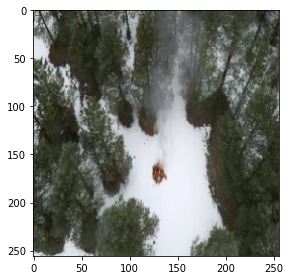

In [ ]:
path = "/content/drive/MyDrive/Dataset_wildfire_1/result/alpha_40ep"
model =  load_model(path)
coloring(model, 3, 256)

# Gradual Learning with saved model

In [ ]:
path = "/content/drive/MyDrive/Dataset_wildfire_1/result/model_40ep_alpha_wm_big"
model =  load_model(path)
k=0
for i in range(40,86):
    X = dataset_init(1, 30*i, 256)
    Xtrain = np_resc(X)

    history, model = train(model, 10, 40)
    # training_eval(history)
    for j in range(30):
        img_tosave = coloring(model, 30*i+j, 256)
        imsave(f"/content/drive/MyDrive/Dataset_wildfire_1/result/40ep_alpha_wm_big_2/im_{k}.png",img_tosave)
        k+=1
model.save( "/content/drive/MyDrive/Dataset_wildfire_1/result/model_40ep_alpha_wm_big_2")



# Gradual Learning big dataset without model

In [ ]:
import time
t1 = time.time()
frames = 300
g = 30
it1 = int(frames / g)

path = "/content/drive/MyDrive/common_videos/images/foreman"
p1 = path
model =  create_model_alpha()
k=0
for i in range(0,it1):
    # print(f"i iteration is : {i}")
    X = load_im(path, g * i, size = 256, number_to_load=1 )
    Xtrain = np_resc(X)

    history, model = train(model, 10, 40)
    # training_eval(history)
    for j in range(g):
        # print(f"i = {i}")
        # print(f"j = {j}")
        print(f"shift is : {g*i+j}")
        img_tosave = coloring(model,path , shift = g*i+j, size = 256)
        if type(img_tosave) == bool:
          print(f"break in j = {j}")
          break;
        imsave(f"/content/drive/MyDrive/common_videos/results/foreman_{g}g_40-10/result_{k}.jpg",img_tosave)
        k+=1
model.save( f"/content/drive/MyDrive/common_videos/models/model_foreman_{g}g_40-10")

t2 = time.time()
dt = t2 - t1
print(dt)
p2 = f"/content/drive/MyDrive/common_videos/results/foreman_{g}g_40-10"


In [ ]:
text = """psnr_lab_avg: 42.01018972722608
psnr_avg: 28.142654519195524
psnr_r_avg: 27.211788321651447
psnr_g_avg: 33.63836766231727
psnr_b_avg: 26.574272553361922
ssim_avg: 0.78163330370085597"""

print(text.replace(':','.append'))


psnr_lab_avg.append 42.01018972722608
psnr_avg.append 28.142654519195524
psnr_r_avg.append 27.211788321651447
psnr_g_avg.append 33.63836766231727
psnr_b_avg.append 26.574272553361922
ssim_avg.append 0.78163330370085597


# make video

In [ ]:
import cv2
import os

image_folder = '/content/drive/MyDrive/common_videos/results/wildfire1_1024_25g-10-10'
video_name = 'wildfire1_1024.avi'

images = [img for img in os.listdir(image_folder) if img.endswith(".jpg")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

# video = cv2.VideoWriter(video_name, 0, 1, (width,height))
video = cv2.VideoWriter(video_name,cv2.VideoWriter_fourcc('M','J','P','G'), 25, (width,height))
list_of_files = os.listdir(image_folder)
list_of_files = sorted(list_of_files, key=lambda f: int(f.split('_')[1].split('.')[0]))
  
for image in tqdm(list_of_files):
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()

100%|██████████| 300/300 [00:04<00:00, 70.43it/s] 


# Extract video

In [ ]:

def extract_video(path):
  # Opens the Video file
  path = Path(path)
  cap= cv2.VideoCapture(str(path))
  i=0
  while(cap.isOpened()):
      ret, frame = cap.read()
      if ret == False:
          break
      save_path = f"/content/drive/MyDrive/common_videos/images/foreman_{bitrate}/" + f'frame{str(i)}.jpg'
      cv2.imwrite(str(save_path),frame)
      i+=1
  
  cap.release()
  cv2.destroyAllWindows()
input = [128,256,512,1024,2000,4000]
for bitrate in input:
  path = f"/content/drive/MyDrive/common_videos/videos/foreman_{bitrate}.mp4"
  output_folder = f"/content/drive/MyDrive/common_videos/images/foreman_{bitrate}"
  Path(output_folder).mkdir(parents=False, exist_ok=True)
  extract_video(path)

In [ ]:
import time
input = [128,256,512,1024,2000,4000]
input = [4000]
results = {}
for bitrate in input:
    print(bitrate)
    t1 = time.time()
    numOf_frame = 300
    g = 25
    it1 = int(numOf_frame/g)
    path = f"/content/drive/MyDrive/common_videos/images/foreman_{bitrate}/"
    p1 = path
    out = f"/content/drive/MyDrive/common_videos/results/foreman_{bitrate}_{g}g-40-10"
    Path(out).mkdir(parents=False, exist_ok=True)
    model =  create_model_alpha()
    k=0
    for i in range(0,it1):
        # print(f"i iteration is : {i}")
        X = load_im(path, g * i, size = 256, number_to_load=1 )
        Xtrain = np_resc(X)

        history, model = train(model, 10, 40)
        # training_eval(history)
        for j in range(g):
            # print(f"i = {i}")
            # print(f"j = {j}")
            print(f"shift is : {g*i+j}")
            img_tosave = coloring(model,path , shift = g*i+j, size = 256)
            if type(img_tosave) == bool:
              print(f"break in j = {j}")
              break;
            imsave(f"/content/drive/MyDrive/common_videos/results/foreman_{bitrate}_{g}g-40-10/result_{k}.jpg",img_tosave)
            k+=1
    model.save( f"/content/drive/MyDrive/common_videos/results/model_foreman_{bitrate}_{g}g-40-10")

    t2 = time.time()
    dt = t2 - t1
    print(dt)
    p2 = f"/content/drive/MyDrive/common_videos/results/foreman_{bitrate}_{g}g-40-10"
    p1 = "/content/drive/MyDrive/common_videos/images/foreman"
    psnr_lab, psnr, psnr_r, psnr_g, psnr_b, ssim_ = psnr_analyze(p1, p2,0, 0, numOf_frame)
    results[f'psnr_lab_{bitrate}'] = sum(psnr_lab)/len(psnr_lab)
    results[f'psnr_avg_{bitrate}'] = sum(psnr)/len(psnr)
    results[f'psnr_r_avg_{bitrate}'] = sum(psnr_r)/len(psnr_r)
    results[f'psnr_g_avg_{bitrate}'] = sum(psnr_g)/len(psnr_g)
    results[f'psnr_b_avg_{bitrate}'] = sum(psnr_b)/len(psnr_b)
    results[f'ssim_avg_{bitrate}'] =sum(ssim_)/len(ssim_)
    # break;
    # plot_psnr("lab channels", psnr_lab)
    # plot_psnr("RGB Channels", psnr)
    # plot_psnr("Red Channel",psnr_r)
    # plot_psnr("Green Channel",psnr_g)
    # plot_psnr("Blue Channel",psnr_b)
    # plot_psnr("SSIM",ssim_)
    # print("psnr_lab_avg:",sum(psnr_lab)/len(psnr_lab))
    # print("psnr_avg:",sum(psnr)/len(psnr))
    # print("psnr_r_avg:",sum(psnr_r)/len(psnr_r))
    # print("psnr_g_avg:",sum(psnr_g)/len(psnr_g))
    # print("psnr_b_avg:",sum(psnr_b)/len(psnr_b))
    # print("ssim_avg:",sum(ssim_)/len(ssim_))


# Training parameters -> PSNR & TIME

In [ ]:
import time
ep = [10,40,10,40]
spe = [1,1,10,10]
codename = "akiyo"
# ep = [5]
# spe = [1]
# spe = [1,1,10,10]
elapsed_times=[]
results = {}
for ep_, spe_ in zip(ep, spe):
    print(ep_, spe_)
    t1 = time.time()
    numOf_frame = 300
    g = 25
    it1 = int(numOf_frame/g)
    path = f"/content/drive/MyDrive/common_videos/images/{codename}_4000/"
    p1 = path
    out = f"/content/drive/MyDrive/common_videos/results/{codename}_{ep_},{spe_}_{g}g-10-1"
    Path(out).mkdir(parents=False, exist_ok=True)
    model =  create_model_alpha()
    k=0
    for i in range(0,it1):
        # print(f"i iteration is : {i}")
        X = load_im(path, g * i, size = 256, number_to_load=1 )
        Xtrain = np_resc(X)

        history, model = train(model, spe_, ep_)
        # training_eval(history)
        for j in range(g):
            # print(f"i = {i}")
            # print(f"j = {j}")
            # print(f"shift is : {g*i+j}")
            img_tosave = coloring(model,path , shift = g*i+j, size = 256)
            if type(img_tosave) == bool:
              print(f"break in j = {j}")
              break;
            # imsave(f"/content/drive/MyDrive/common_videos/results/{codename}_{ep_},{spe_}_{g}g-10-1/result_{k}.jpg",img_tosave)
            k+=1
    # model.save( f"/content/drive/MyDrive/common_videos/results/model_{codename}_{ep_},{spe_}_{g}g-10-1")

    t2 = time.time()
    dt = t2 - t1
    elapsed_times.append(dt)
print(elapsed_times)
    # print(dt)
    # p2 = f"/content/drive/MyDrive/common_videos/results/{codename}_{ep_},{spe_}_{g}g-10-1"
    # psnr_lab, psnr, psnr_r, psnr_g, psnr_b, ssim_ = psnr_analyze(p1, p2,0, 0, numOf_frame)
    # results[f'psnr_lab_{ep_}_{spe_}'] = sum(psnr_lab)/len(psnr_lab)
    # results[f'psnr_avg_{ep_}_{spe_}'] = sum(psnr)/len(psnr)
    # results[f'psnr_r_avg_{ep_}_{spe_}'] = sum(psnr_r)/len(psnr_r)
    # results[f'psnr_g_avg_{ep_}_{spe_}'] = sum(psnr_g)/len(psnr_g)
    # results[f'psnr_b_avg_{ep_}_{spe_}'] = sum(psnr_b)/len(psnr_b)
    # results[f'ssim_avg_{ep_}_{spe_}'] =sum(ssim_)/len(ssim_)
    # break;
    # plot_psnr("lab channels", psnr_lab)
    # plot_psnr("RGB Channels", psnr)
    # plot_psnr("Red Channel",psnr_r)
    # plot_psnr("Green Channel",psnr_g)
    # plot_psnr("Blue Channel",psnr_b)
    # plot_psnr("SSIM",ssim_)
    # print("psnr_lab_avg:",sum(psnr_lab)/len(psnr_lab))
    # print("psnr_avg:",sum(psnr)/len(psnr))
    # print("psnr_r_avg:",sum(psnr_r)/len(psnr_r))
    # print("psnr_g_avg:",sum(psnr_g)/len(psnr_g))
    # print("psnr_b_avg:",sum(psnr_b)/len(psnr_b))
    # print("ssim_avg:",sum(ssim_)/len(ssim_))


In [ ]:
ep = [10,10,40,40]
spe = [1,10,1,10]
for e,s in zip(ep, spe):
  print(e,s)

10 1
10 10
40 1
40 10


In [ ]:
path = "/content/drive/MyDrive/Dataset_wildfire_1/result/huge_fire_40ep"
list_of_files = os.listdir(path)
for file in list_of_files:
  print(file)
list_of_files = sorted(list_of_files, key=lambda f: int(f.split('frame')[1].split('.')[0]))

In [ ]:
import functools
from time import perf_counter
def timer(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        t1 = perf_counter()
        output = func(*args, **kwargs)
        t2 = perf_counter()
        print(f"passed time : {t2-t1}")
        return output
    return wrapper

In [ ]:
print(elapsed_times)

[173.8852756023407, 210.8098738193512, 193.17346453666687, 221.21734929084778]


[36.86260458940749, 38.96391065925794, 39.91700100937814, 40.50330064519393, 40.749385465563286, 40.98004540352525]
[24.257477225354343, 25.384477905527515, 25.12126570680615, 25.343351045657407, 25.25327669840194, 25.57153265993269]
[23.456232784933277, 24.359473768319887, 24.33181294642158, 24.224853517158603, 24.269331901319756, 24.588733490185106]
[29.106958477862154, 30.781148482074908, 31.439573721585276, 31.66314419077232, 31.79692038582744, 32.03474359776042]
[22.649668050902246, 23.876492941296284, 23.364973401439574, 23.755359882298706, 23.49964428526811, 23.846387046834312]
[0.5983433676650072, 0.695187880780154, 0.7369164586545109, 0.7506902175997154, 0.759566984261273, 0.7772149720762426]


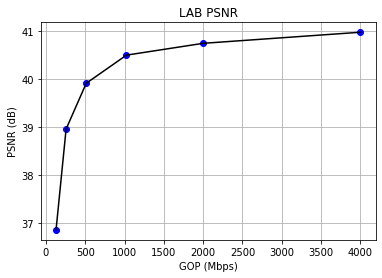

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
s = []
psnr_lab_avg = []
psnr_avg = []
psnr_r_avg = []
psnr_g_avg = []
psnr_b_avg = []
ssim_avg = []

t = input
for bitrate in input:
    psnr_lab_avg.append(results[f'psnr_lab_{bitrate}'])
    psnr_avg.append(results[f'psnr_avg_{bitrate}'])
    psnr_r_avg.append(results[f'psnr_r_avg_{bitrate}'])
    psnr_g_avg.append(results[f'psnr_g_avg_{bitrate}'])
    psnr_b_avg.append(results[f'psnr_b_avg_{bitrate}'])
    ssim_avg.append(results[f'ssim_avg_{bitrate}'])
print(psnr_lab_avg)
print(psnr_avg)
print(psnr_r_avg)
print(psnr_g_avg)
print(psnr_b_avg)
print(ssim_avg)

plt.rcParams["font.family"] = "Times New Roman"

fig, ax1= plt.subplots()
ax1.plot(t, psnr_lab_avg, 'bo',t,psnr_lab_avg,'k')

ax1.set(xlabel='GOP (Mbps)', ylabel='PSNR (dB)',
       title='LAB PSNR')
ax1.grid()
plt.show()





#ep spe

[41.31720392436389, 41.48922051883698, 41.64877517614565, 42.12650364716861]
[25.97354428664668, 26.529602574739627, 27.04526027354976, 28.55221543502353]
[24.84957074521037, 25.431271180509885, 25.95278196143047, 27.47886093041166]
[32.27383556638549, 32.59600943832417, 32.869124317737416, 33.73596617615054]
[24.39065213000973, 24.96633006208896, 25.53751975864842, 27.17918345984854]
[0.7835065283782587, 0.7825001928626204, 0.782672417388219, 0.7817965259338202]


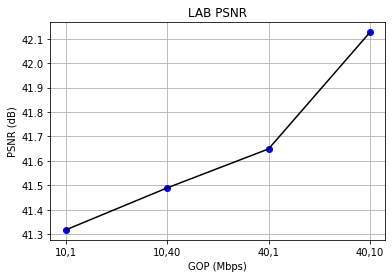

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
s = []
psnr_lab_avg = []
psnr_avg = []
psnr_r_avg = []
psnr_g_avg = []
psnr_b_avg = []
ssim_avg = []

t = ['10,1', '10,40','40,1', '40,10']
for ep_, spe_ in zip(ep,spe):
    psnr_lab_avg.append(results[f'psnr_lab_{ep_}_{spe_}'])
    psnr_avg.append(results[f'psnr_avg_{ep_}_{spe_}'])
    psnr_r_avg.append(results[f'psnr_r_avg_{ep_}_{spe_}'])
    psnr_g_avg.append(results[f'psnr_g_avg_{ep_}_{spe_}'])
    psnr_b_avg.append(results[f'psnr_b_avg_{ep_}_{spe_}'])
    ssim_avg.append(results[f'ssim_avg_{ep_}_{spe_}'])
print(psnr_lab_avg)
print(psnr_avg)
print(psnr_r_avg)
print(psnr_g_avg)
print(psnr_b_avg)
print(ssim_avg)

plt.rcParams["font.family"] = "Times New Roman"
elapsed_times = [173.8852756023407, 193.17346453666687,210.8098738193512, 221.21734929084778]

fig, ax1= plt.subplots()
ax1.plot(t, psnr_lab_avg, 'bo',t,psnr_lab_avg,'k')

ax1.set(xlabel='GOP (Mbps)', ylabel='PSNR (dB)',
       title='LAB PSNR')
ax1.grid()
plt.show()


In [ ]:
import time
gop = [5, 10, 15 , 20, 25, 30]
results = {}
elapsed_times = []
codename = "akiyo_4000"
for g in gop:
    print(g)
    t1 = time.time()
    numOf_frame = 300
    it1 = int(numOf_frame/g)
    path = f"/content/drive/MyDrive/common_videos/images/{codename}/"
    p1 = path
    out = f"/content/drive/MyDrive/common_videos/results/{codename}_{g}g-10-1"
    Path(out).mkdir(parents=False, exist_ok=True)
    model =  create_model_alpha()
    k=0
    for i in range(0,it1):
        # print(f"i iteration is : {i}")
        X = load_im(path, g * i, size = 256, number_to_load=1 )
        Xtrain = np_resc(X)

        history, model = train(model, 1, 10)
        # training_eval(history)
        for j in range(g):
            # print(f"i = {i}")
            # print(f"j = {j}")
            # print(f"shift is : {g*i+j}")
            img_tosave = coloring(model,path , shift = g*i+j, size = 256)
            if type(img_tosave) == bool:
              print(f"break in j = {j}")
              break;
            # imsave(f"/content/drive/MyDrive/common_videos/results/{codename}_{g}g-10-1/result_{k}.jpg",img_tosave)
            k+=1
    # model.save( f"/content/drive/MyDrive/common_videos/results/model_{codename}_{g}g-10-1")

    t2 = time.time()
    dt = t2 - t1
    elapsed_times.append(dt)

    # print(dt)
    # p2 = f"/content/drive/MyDrive/common_videos/results/{codename}_{g}g-10-1"
    # p1 = f"/content/drive/MyDrive/common_videos/images/{codename}"
    # psnr_lab, psnr, psnr_r, psnr_g, psnr_b, ssim_ = psnr_analyze(p1, p2,0, 0, numOf_frame)
    # results[f'psnr_lab_{g}'] = sum(psnr_lab)/len(psnr_lab)
    # results[f'psnr_avg_{g}'] = sum(psnr)/len(psnr)
    # results[f'psnr_r_avg_{g}'] = sum(psnr_r)/len(psnr_r)
    # results[f'psnr_g_avg_{g}'] = sum(psnr_g)/len(psnr_g)
    # results[f'psnr_b_avg_{g}'] = sum(psnr_b)/len(psnr_b)
    # results[f'ssim_avg_{g}'] =sum(ssim_)/len(ssim_)
print(elapsed_times)



In [ ]:
k

300

In [ ]:
from siti_tools.siti import calculate_si_ti

si_values, ti_values, frame_count = calculate_si_ti("/content/drive/MyDrive/common_videos/videos/wildfire.mp4")
print(si_values)
print(ti_values)
print(frame_count)
wildfire_time = [69.15024876594543, 56.95998525619507, 53.2674343585968, 50.926652908325195, 49.925819396972656, 49.11827063560486]


[57.17202517891868]
[0.0]
1


In [ ]:
k

270

[41.448389714278804, 41.5217927186826, 41.22481828773033, 41.23027971905069, 41.23376462817959, 40.770676004368305]
[26.456956203601056, 26.641569407835405, 25.61816759822169, 25.616165646668893, 25.623005763012706, 24.526373594592062]
[25.278643947437732, 25.478953454670453, 24.464547630297403, 24.48240838004425, 24.566408018453867, 23.200838969867288]
[32.48855826750521, 32.618450290488695, 32.11116214040008, 32.10874428310911, 32.14891441910792, 31.215493369866557]
[24.96250207300446, 25.146728288084464, 24.04366704873466, 24.00134526948207, 23.943785112891717, 23.099284506125066]
[0.7835504669520649, 0.7845585748646702, 0.7820157935493938, 0.7752943392358472, 0.7808775038187442, 0.7470753326741437]


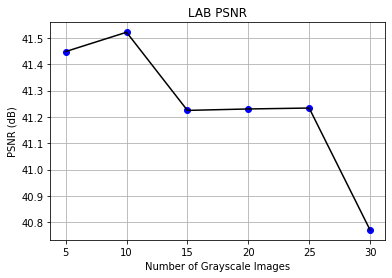

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
s = []
psnr_lab_avg = []
psnr_avg = []
psnr_r_avg = []
psnr_g_avg = []
psnr_b_avg = []
ssim_avg = []

t = [5, 10, 15, 20, 25, 30]
for g in gop:
    psnr_lab_avg.append(results[f'psnr_lab_{g}'])
    psnr_avg.append(results[f'psnr_avg_{g}'])
    psnr_r_avg.append(results[f'psnr_r_avg_{g}'])
    psnr_g_avg.append(results[f'psnr_g_avg_{g}'])
    psnr_b_avg.append(results[f'psnr_b_avg_{g}'])
    ssim_avg.append(results[f'ssim_avg_{g}'])
print(psnr_lab_avg)
print(psnr_avg)
print(psnr_r_avg)
print(psnr_g_avg)
print(psnr_b_avg)
print(ssim_avg)

plt.rcParams["font.family"] = "Times New Roman"

fig, ax1= plt.subplots()
ax1.plot(t, psnr_lab_avg, 'bo',t,psnr_lab_avg,'k')

ax1.set(xlabel='Number of Grayscale Images', ylabel='PSNR (dB)',
       title='LAB PSNR')
ax1.grid()
plt.show()





In [ ]:
[173.8852756023407, 210.8098738193512, 193.17346453666687, 221.21734929084778]


In [ ]:
complete image : imgSize(e.g: 96*96)pixels  * 8 (bit/byte) * 10 byte/pixel    / 19200(bit/s) = 38.4 (sec)  
one channel : 38.4 / 3  (sec)
one full cycle (M frame): 1 complete image + M-1 one channel

In [ ]:
name = "/content/drive/MyDrive/Dataset_wildfire_1/result/huge_fire_40ep/frame0.jpg"
original = img_to_array(load_img(name))
original = original[150:,:,:]
original = original[0:700,:,:]
original = resize(original,(256,256))
imsave("/content/drive/MyDrive/Dataset_wildfire_1/result/temp/1.jpg", original)

IsADirectoryError: ignored

In [ ]:
  path = "/content/drive/MyDrive/Dataset_wildfire_1/result/huge_fire_40ep/"
  list_of_files = os.listdir(path)
  list_of_files = sorted(list_of_files, key=lambda f: int(f.split(f'{"frame"}')[1].split('.')[0]))
  list_of_files

# data

#psnrhsvm

In [ ]:
import numpy as np
from scipy import ndimage as ndi
from matplotlib import pyplot as plt
import matplotlib.cm as cm

from skimage import data
from skimage import color
from skimage.util import view_as_blocks

# Generated with SMOP  0.41
# psnrhvsm.m
import numpy as np
import scipy as sp
from scipy.fftpack import dct, dctn, idctn
from skimage.util.shape import view_as_windows, view_as_blocks

from PIL import Image

def psnrhvsm(img1=None,img2=None,wstep=8,*args,**kwargs):
    varargin = args
    nargin = 2 + len(varargin)
    verbose = True
    p_hvs_m = 0 
    p_hvs = 0
    
    '''
    ========================================================================
        
        Calculation of PSNR-HVS-M and PSNR-HVS image quality measures
        
        PSNR-HVS-M is Peak Signal to Noise Ratio taking into account 
        Contrast Sensitivity Function (CSF) and between-coefficient   
        contrast masking of DCT basis functions
        PSNR-HVS is Peak Signal to Noise Ratio taking into account only CSF
        
         Copyright(c) 2006 Nikolay Ponomarenko 
          All Rights Reserved
        
         Homepage: http://ponomarenko.info, E-mail: nikolay{}ponomarenko.info
        
        ----------------------------------------------------------------------
        
        # Permission to use, copy, or modify this software and its documentation
        for educational and research purposes only and without fee is hereby
        granted, provided that this copyright notice and the original authors'
        names appear on all copies and supporting documentation. This program
        shall not be used, rewritten, or adapted as the basis of a commercial
        software or hardware product without first obtaining permission of the
        authors. The authors make no representations about the suitability of
        this software for any purpose. It is provided "as is" without express
         or implied warranty.
        
        #----------------------------------------------------------------------
        
        This is an implementation of the algorithm for calculating the PSNR-HVS-M
        or PSNR-HVS between two images. Please refer to the following papers:
       
       # PSNR-HVS-M:
         [1] Nikolay Ponomarenko, Flavia Silvestri, Karen Egiazarian, Marco Carli, 
             Jaakko Astola, Vladimir Lukin, "On between-coefficient contrast masking 
             of DCT basis functions", CD-ROM Proceedings of the Third International 
             Workshop on Video Processing and Quality Metrics for Consumer Electronics 
             VPQM-07, Scottsdale, Arizona, USA, 25-26 January, 2007, 4 p.
           
           # PSNR-HVS:
         [2] K. Egiazarian, J. Astola, N. Ponomarenko, V. Lukin, F. Battisti, 
             M. Carli, New full-reference quality metrics based on HVS, CD-ROM 
             Proceedings of the Second International Workshop on Video Processing 
             and Quality Metrics, Scottsdale, USA, 2006, 4 p.
       
        Kindly report any suggestions or corrections to uagames{}mail.ru
       
       #----------------------------------------------------------------------
       
       # Input : (1) img1: the first image being compared
                 (2) img2: the second image being compared
                 (3) wstep: step of 8x8 window to calculate DCT 
                     coefficients. Default value is 8.
           
       # Output: (1) p_hvs_m: the PSNR-HVS-M value between 2 images.
                     If one of the images being compared is regarded as 
                     perfect quality, then PSNR-HVS-M can be considered as the
                     quality measure of the other image.
                     If compared images are visually undistingwished, 
                     then PSNR-HVS-M = 100000.
                 (2) p_hvs: the PSNR-HVS value between 2 images.
        
        # Default Usage:
            Given 2 test images img1 and img2, whose dynamic range is 0-255
        
           [p_hvs_m, p_hvs] = psnrhvsm(img1, img2);
        
             See the results:
            
             p_hvs_m  # Gives the PSNR-HVS-M value
             p_hvs    # Gives the PSNR-HVS value
    ========================================================================
    '''  
    if nargin < 2:
        p_hvs_m =- Inf
        p_hvs =- Inf
        print('returned on narngin')
        return p_hvs_m,p_hvs
    
    if img1.size != img2.size:
        p_hvs_m=- Inf
        p_hvs=- Inf

        print('returned on img seizes')
        return p_hvs_m,p_hvs
    
    if nargin > 2:
        step=wstep
    else:
        step=8
    
    #img1= img1.detach().cpu().clone().numpy()[0,:,:]
    #img2= img2.detach().cpu().clone().numpy()[0,:,:]
    #print(img1.shape)
    #img1 = np.transpose(img1,[1,2,0])
    #img2 = np.transpose(img2,[1,2,0])
    
    LenXY= img1.shape
    print(LenXY)
    LenX = LenXY
    LenY = LenXY
    print('lenx: {:.0f}, leny: {:.0f}'.format(LenX,LenY))

    CSFCof=np.array([[1.608443, 2.339554, 2.573509, 1.608443, 1.072295, 0.643377, 0.504610, 0.421887],
                   [2.144591, 2.144591, 1.838221, 1.354478, 0.989811, 0.443708, 0.428918, 0.467911],
                   [1.838221, 1.979622, 1.608443, 1.072295, 0.643377, 0.451493, 0.372972, 0.459555],
                   [1.838221, 1.513829, 1.169777, 0.887417, 0.504610, 0.295806, 0.321689, 0.415082],
                   [1.429727, 1.169777, 0.695543, 0.459555, 0.378457, 0.236102, 0.249855, 0.334222],
                   [1.072295, 0.735288, 0.467911, 0.402111, 0.317717, 0.247453, 0.227744, 0.279729],
                   [0.525206, 0.402111, 0.329937, 0.295806, 0.249855, 0.212687, 0.214459, 0.254803],
                   [0.357432, 0.279729, 0.270896, 0.262603, 0.229778, 0.257351, 0.249855, 0.25995]])
    # see an explanation in [2]
    
    MaskCof=np.array([[0.390625, 0.826446, 1.000000, 0.390625, 0.173611, 0.062500, 0.038447, 0.026874],
                    [0.694444, 0.694444, 0.510204, 0.277008, 0.147929, 0.029727, 0.027778, 0.033058],
                    [0.510204, 0.591716, 0.390625, 0.173611, 0.062500, 0.030779, 0.021004, 0.031888],
                    [0.510204, 0.346021, 0.206612, 0.118906, 0.038447, 0.013212, 0.015625, 0.026015],
                    [0.308642, 0.206612, 0.073046, 0.031888, 0.021626, 0.008417, 0.009426, 0.016866],
                    [0.173611, 0.081633, 0.033058, 0.024414, 0.015242, 0.009246, 0.007831, 0.011815],
                    [0.041649, 0.024414, 0.016437, 0.013212, 0.009426, 0.006830, 0.006944, 0.009803],
                    [0.019290, 0.011815, 0.011080, 0.010412, 0.007972, 0.010000, 0.009426, 0.010203]])
    # see an explanation in [1]
    
    S1=0
    S2=0
    Num=0
    X=0
    Y=0
    #while Y <= LenY - 7:
    #    while X <= LenX - 7:
            #rangeB = np.arange(Y,Y+7)
            #rangeA = np.arange(X,X+7)
    window_shape = (8, 8)
    #TODO: PORT TO PYTHON HOW TO GET A WINDOW/patch from the array.
    #A=img1[rangeA,rangeB]
    #B=img2[rangeA,rangeB]

    A = view_as_blocks(img1, window_shape)
    B = view_as_blocks(img2, window_shape)
    print('A shape:',A.shape)
    num_patchsA = A.shape[0]
    num_patchsB = B.shape[0]
    for p in range(num_patchsA):
        for py in range(num_patchsB):
    #compute the 2d Discrete Cosine Transform
            patchA = A[p][py]
            patchB = B[p][py]
            #print('patch a', patchA.shape)
            #print('patch b', patchB.shape)
            '''Thanks to 
            https://www.tu-ilmenau.de/fileadmin/public/mt_ams/GrundlagenDerVideotechnikb/Vorlesung/WS_2017-18/06_16-11-28DCT_-_English.pdf
            that explains how dct work and should be modified for 2d images. 
            '''
            #dct2(A)
            a_dct=dct(patchA,type=2,axis=1,norm='ortho')
            A_dct=dct(a_dct,type=2,axis=0,norm='ortho')
            #dct2(B)
            b_dct=dct(patchB,type=2,axis=1,norm='ortho')
            B_dct=dct(b_dct,type=2,axis=0,norm='ortho')
            
            #print('A_dct: ', A_dct.shape)
            #print('B_dct: ', B_dct.shape)
            
            MaskA=maskeff(patchA,A_dct)
            MaskB=maskeff(patchB,B_dct)
            #print('MaskA',MaskA.shape)
            #print('MaskB',MaskB.shape)
            if MaskB > MaskA:
                MaskA= MaskB.copy()
            #X=X + step
            for k in range(7):
                for l in range(7):
                    u=abs(A_dct[k,l] - B_dct[k,l])
                    S2=S2 + ((np.dot(u,CSFCof[k,l]))**2) #PSNR-hvs
                    if (k != 1) or (l != 1):
                        if u < MaskA / MaskCof[k,l]:
                            u=0
                        else:
                            u=u - (MaskA / MaskCof[k,l])
                    S1=S1 + ((np.dot(u,CSFCof[k,l]))** 2) # PSNR-HVS-M
                    Num=Num + 1
    
    if Num != 0:
        S1= S1/Num
        S2= S2/Num
        if S1 == 0:
            p_hvs_m=100000
            print("p_hvs_m=100000")
        else:
            p_hvs_m= 10*(np.log10(255*(255/ S1)))
            print('p_hvs_m: {:.0f}'.format(p_hvs_m))
        if S2 == 0:
            print("p_hvs=100000")
            p_hvs=100000
        else:
            p_hvs= 10*(np.log10(255*(255 / S2)))
            print('p_hvs: {:.0f}'.format(p_hvs))
    print('returned on end of loop')  
    print(p_hvs_m)
    print(p_hvs)
    return p_hvs_m, p_hvs
    
    
def maskeff(z=None,zdct=None,*args,**kwargs):
    varargin = args
    nargin = 2 + len(varargin)
    
    # Calculation of Enorm value (see [1])
    m=0
    MaskCof=np.array([[0.390625, 0.826446, 1.000000, 0.390625, 0.173611, 0.062500, 0.038447, 0.026874],
                    [0.694444, 0.694444, 0.510204, 0.277008, 0.147929, 0.029727, 0.027778, 0.033058],
                    [0.510204, 0.591716, 0.390625, 0.173611, 0.062500, 0.030779, 0.021004, 0.031888],
                    [0.510204, 0.346021, 0.206612, 0.118906, 0.038447, 0.013212, 0.015625, 0.026015],
                    [0.308642, 0.206612, 0.073046, 0.031888, 0.021626, 0.008417, 0.009426, 0.016866],
                    [0.173611, 0.081633, 0.033058, 0.024414, 0.015242, 0.009246, 0.007831, 0.011815],
                    [0.041649, 0.024414, 0.016437, 0.013212, 0.009426, 0.006830, 0.006944, 0.009803],
                    [0.01929, 0.0118150, 0.011080, 0.010412, 0.007972, 0.010000, 0.009426, 0.010203]])
    # see an explanation in [1]
    
    for k in range(7):
        for l in range(7):
            if (k != 1) or (l != 1):
                m=m + np.dot((zdct[k,l] ** 2),MaskCof[k,l])
    
    pop=vari(z)
    #print('pop: ', pop)
    #print('z shape:', z.shape)
    if pop != 0:
        block1 = vari(z[0:3, 0:3])
        block2 = vari(z[0:3, 4:7])
        block3 = vari(z[4:7, 4:7])
        block4 = vari(z[4:7, 0:3])
        '''
        print('block1', block1.shape)
        print('block1', block2.shape)
        print('block1', block3.shape)
        print('block1', block4.shape)
        '''
        pop=(block1 + block2 + block3 + block4 ) / pop
    
    m=np.sqrt(np.dot(m,pop)) / 32

    return m
    
def vari(AA=None,*args,**kwargs):
    varargin = args
    nargin = 1 + len(varargin)
    flat = AA.flatten(order='C')
    varia = np.var(flat)
    #flat_sz = np.size(flat)
    
    #print(flat)
    #print(varia)
    #print(flat_sz)
    d=np.dot(varia, flat.size)
    return d


def print_v(message='', verbose =False):
    if verbose == True:
        print(message)

In [ ]:
img_c = load_im("/content/drive/MyDrive/colabData_1/", 0, 256,1)
img_n = load_im("/content/drive/MyDrive/Dataset_wildfire_1/result/40ep_alpha_wm_big", 0, 256, 1, split_phrase='_')
imask = np.array(img_c)
noise = np.array(img_n)
print(imask.shape)
psnrhvsm(noise,imask)

print('p_hvs_m: {:.0f} dB'.format(p1))
print('p_hvs: {:.0f} dB'.format(p2))

(1, 256, 256, 3)
(1, 256, 256, 3)


TypeError: ignored